### Low Level Primitives

This notebook illustrates how to use the low-level shadow mapping primitives for designing custom renderers.

In [1]:
import matplotlib.pyplot as plt
import math
import nvdiffrast.torch as dr
import torch

from diffshadow import *
from diffshadow.simple_renderer import load_mesh, weld_seams, Mesh, create_plane_mesh, merge_meshes
from utilities import *

device         = torch.device('cuda:0')
render_context = dr.RasterizeGLContext(device=device)

##### 1) Basic Usage

Create a scene consisting of a (randomly colored) spot and a single white ground plane

In [2]:
spot                = weld_seams(Mesh(*load_mesh("data/spot.obj", device=device)))
spot.diffuse_albedo = torch.rand_like(spot.vertices)

plane                = create_plane_mesh([0, -0.8, 0], [0, 1, 0], size=2, device=device)
plane.diffuse_albedo = torch.ones_like(plane.vertices)

# Merge both meshes into one scene mesh
scene_mesh = merge_meshes([spot, plane])

c:\Users\mworchel\Documents\work\code\differentiable-shadow-mapping\diffshadow\simple_renderer\mesh_io.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  vertex_normals = torch.from_numpy(mesh.vertex_normals).to(device, dtype=torch.float32)


Render the scene and display the individual triangles

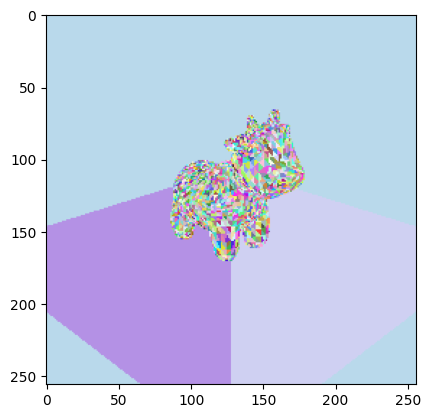

In [3]:
view_matrix       = create_lookat_matrix([4, 2, -4], [0, -0.2, 0], [0, 1, 0]).to(device)
projection_matrix = create_perspective_projection_matrix(fovy=35, near=0.1, far=10, device=device)

v_clipspace = homogeneous(scene_mesh.vertices) @ (projection_matrix @ view_matrix).T

rast_out, _ = dr.rasterize(render_context, v_clipspace[None], scene_mesh.faces, resolution=(256, 256))

colors = torch.rand((scene_mesh.faces.shape[0]+1, 3), device=device)
plt.imshow(to_display_image(colors[rast_out[0, :, :, 3].to(torch.long)]))

The function `render_shadow_map` is the first primitive to use for shadow rendering. It creates a shadow map from a scene mesh and a light source (the interface for passing the geometry is similar to `dr.rasterize`).

The resolution of the returned shadow map is determined by the `resolution` parameter to the light source (in this example it is $512 \times 512$).

A Variance Shadow Map will be created since the mode is specified as `ShadowMethod.VarianceShadowMaps`. It can be changed to `ShadowMethod.Standard` for standard shadow mapping. Standard shadow maps will have the member `shadow_map.depth` instead of `shadow_map.m1` and `shadow_map.m2` (direct interaction with these members is only necessary for visualization here).

Text(0.5, 1.0, '2nd Moment')

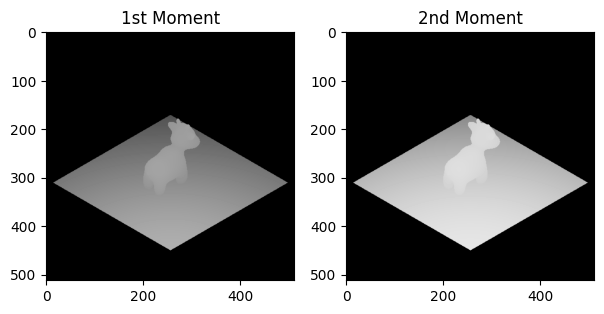

In [4]:
light      = DirectionalLights.create(direction=[1, 1, 1], distance=4, size=3, near=0.01, far=10, resolution=(512, 512), device=device)
shadow_map = render_shadow_map(render_context, scene_mesh.vertices[None], scene_mesh.faces, None, light, ShadowMethod.VarianceShadowMaps)

fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
axs[0].imshow(to_display_image(shadow_map.m1[0], gamma=False), vmin=0, vmax=10, cmap='gray_r')
axs[0].set_title("1st Moment")
axs[1].imshow(to_display_image(shadow_map.m2[0], gamma=False), vmin=0, vmax=100, cmap='gray_r')
axs[1].set_title("2nd Moment")

Pre-filtered shadow mapping techniques involve a filtering stage before computing the visibility. The function `filter_shadow_map` is a shallow abstraction over two filters: nvdiffrast's antialiasing and an explicit smoothing with a compact kernel. The kernel can be passed simply as a 2D tensor.

kernel.shape=torch.Size([7, 7])


Text(0.5, 1.0, '1st Moment (Filtered)')

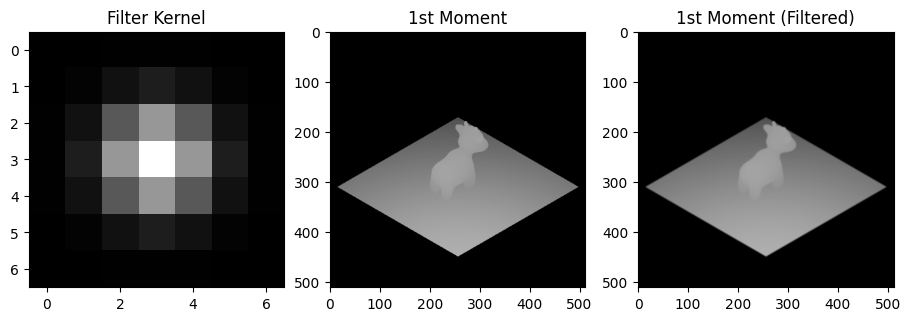

In [5]:
kernel              = get_gaussian_filter_2d(7, device=device)[0, 0]
shadow_map_filtered = filter_shadow_map(shadow_map, antialias=True, kernel=kernel)

print(f"{kernel.shape=}")

fig, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
axs[0].imshow((kernel + 1).log().cpu().numpy(), cmap='gray')
axs[0].set_title("Filter Kernel")
axs[1].imshow(to_display_image(shadow_map.m1[0], gamma=False), vmin=0, vmax=10, cmap='gray_r')
axs[1].set_title("1st Moment")
axs[2].imshow(to_display_image(shadow_map_filtered.m1[0], gamma=False), vmin=0, vmax=10, cmap='gray_r')
axs[2].set_title("1st Moment (Filtered)")

The filtered shadow map is now used to compute the visibility for points visible in the initial camera.

The function `compute_visibility` takes a shadow map and an image of positions and returns the visibility of these points with respect to the light source.

The resulting visibility image can be used for shading or other operations that require visibility.

c:\Users\mworchel\Miniconda3\envs\diffshadow_dev\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Text(0.5, 1.0, 'Shaded with Visibility')

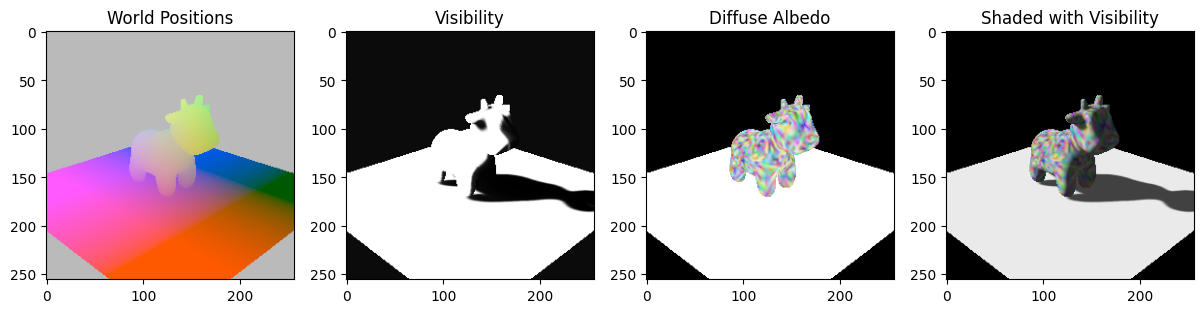

In [6]:
positions, _ = dr.interpolate(scene_mesh.vertices[None], rast_out, scene_mesh.faces)
visibility   = compute_visibility(shadow_map_filtered, positions[None])[0, 0]

# Shade the image using a simple ambient + diffuse model and the computed visibility
img_albedo, _   = dr.interpolate(scene_mesh.diffuse_albedo[None], rast_out, scene_mesh.faces)
normals, _      = dr.interpolate(scene_mesh.normals[None], rast_out, scene_mesh.faces)
_, direction, _ = map_points_to_light_space(light, positions)
LdotN           = dot(direction, normals, keepdim=True).clamp(0, 1)
img_shaded      = 0.05*img_albedo + 0.5 * img_albedo / 2*math.pi * LdotN * visibility

fig, axs = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)
axs[0].imshow(to_display_image(0.5*(positions[0] + 1)))
axs[0].set_title("World Positions")
axs[1].imshow(to_display_image(visibility[0]), cmap='gray')
axs[1].set_title("Visibility")
axs[2].imshow(to_display_image(img_albedo[0]))
axs[2].set_title("Diffuse Albedo")
axs[3].imshow(to_display_image(img_shaded[0]))
axs[3].set_title("Shaded with Visibility")

##### 2) Light-Space Sampling

Under the hood, the shadow map lookups are based on functions for sample light-space images (a combination of `map_points_to_light_space` and `sample_light_space_image`).

These auxiliary functions can be helpful for a custom renderer when light is emitted with spatially varying intensity (e.g. a projector) or in a specific shape (e.g. a flashlight).

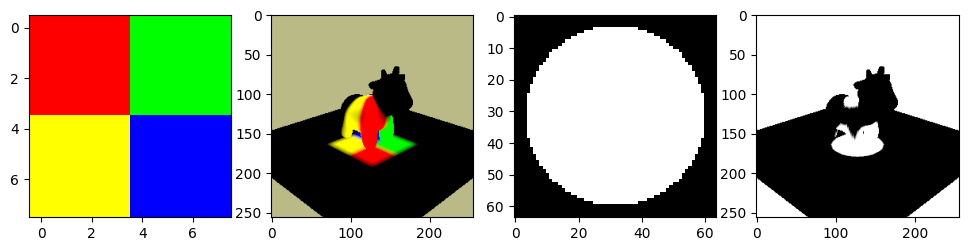

In [9]:
def create_dummy_texture(width, height, device):
    dummy = torch.zeros((height, width, 3), dtype=torch.float32, device=device)

    dummy[:dummy.shape[0]//2, :dummy.shape[1]//2, :] = torch.tensor([1.0, 0.0, 0.0], device=device)
    dummy[:dummy.shape[0]//2, dummy.shape[1]//2:, :] = torch.tensor([0.0, 1.0, 0.0], device=device)
    dummy[dummy.shape[0]//2:, :dummy.shape[1]//2, :] = torch.tensor([1.0, 1.0, 0.0], device=device)
    dummy[dummy.shape[0]//2:, dummy.shape[1]//2:, :] = torch.tensor([0.0, 0.0, 1.0], device=device)

    return dummy

light    = SpotLights.create(create_lookat_matrix([0, 1, 0], [0, 0, 0], [0, 0, 1]), fovy=35, near=0.01, far=10, resolution=(256, 256), device=device)
_, _, uv = map_points_to_light_space(light, positions)

dummy         = create_dummy_texture(8, 8, device)
dummy_sampled = sample_light_space_image(light, repeat_dim(dummy[None], light.view_matrix.shape[0], 0), uv, filter_mode='linear', boundary_mode='zero')


x, y = torch.meshgrid([
    torch.linspace(-1, 1, 64, device=device),
    torch.linspace(-1, 1, 64, device=device)
], indexing='ij')[::-1]

circle         = (x**2 + y**2 - 0.9**2)[:, :, None].repeat((1, 1, 3))
circle         = (circle < 0).to(dtype=torch.float32)
circle_sampled = sample_light_space_image(light, circle[None], uv, filter_mode='linear', boundary_mode='zero')

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(to_display_image(dummy, flip=False))
axs[1].imshow(to_display_image(dummy_sampled[0]))
axs[2].imshow(to_display_image(circle, flip=False))
axs[3].imshow(to_display_image(circle_sampled[0]))

##### 3) Batched Mode

The shadow mapping primitives are designed for operating on batches of scenes, lights, and cameras, which allows efficient visibility computation in settings with many lights or multi-view images.

Create two variations of the same scene (second one is a noised spot) and stack the vertex buffers

In [10]:
scene_mesh_1 = merge_meshes([spot, plane])
scene_mesh_2 = merge_meshes([spot.with_vertices(spot.vertices + 0.1*torch.rand_like(spot.vertices)), plane])

v = torch.stack([scene_mesh_1.vertices, scene_mesh_2.vertices], dim=0)
f = scene_mesh_1.faces

print(f"{v.shape=}")
print(f"{f.shape=}")

v.shape=torch.Size([2, 2934, 3])
f.shape=torch.Size([5858, 3])


Create C random cameras around the scene (all with the same projection matrix) and render the scenes

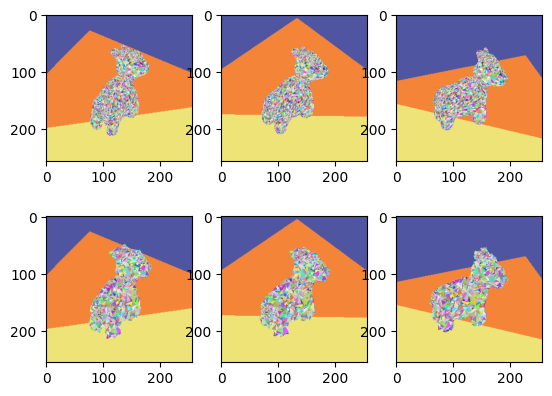

In [11]:
C            = 3
dir          = torch.rand((C, 3))
dist         = torch.rand((C,))+1
view_matrices       = create_view_matrix_from_direction(-dir, dist).to(device=device)
projection_matrices = create_orthographic_projection_matrix(1.5, 0.01, 10, device=device)[None].expand_as(view_matrices)

resolution  = (256, 256)
pre_rast    = prepare_batched_rasterization(v, f, None, view_matrices, projection_matrices)
rast_out, _ = dr.rasterize(render_context, pos=pre_rast.v_clipspace, tri=pre_rast.faces, resolution=(256, 256), ranges=pre_rast.ranges, grad_db=False)

colors = torch.rand((f.shape[0]+1, 3), device=device)
num_cameras = C #min(2, C)
fig, axs = plt.subplots(v.shape[0], num_cameras)
for i in range(v.shape[0]):
    for j in range(num_cameras):
        img = colors[rast_out.view(pre_rast.num_meshes, pre_rast.num_cameras, resolution[0], resolution[1], -1)[i, j, :, :, 3].to(torch.long)]
        axs[i][j].imshow(to_display_image(img))

Create L random point lights and compute the visibility for all scenes, cameras, and lights with a single function call

c:\Users\mworchel\Documents\work\code\differentiable-shadow-mapping\diffshadow\shadow.py:99: UserWarning: Omni-directional point light support is preliminary: filtering can generate visible seams.
  warnings.warn("Omni-directional point light support is preliminary: filtering can generate visible seams.")


The 'position_world' tensor holds the world positions for 2 scenes/meshes and 3 cameras (first two dimensions): position_world.shape=torch.Size([2, 3, 256, 256, 3])
The 'visibility' tensor holds the visibility for 2 scenes/meshes, 3 cameras, and 4 light sources (first three dimensions): visibility.shape=torch.Size([2, 3, 4, 256, 256, 1])


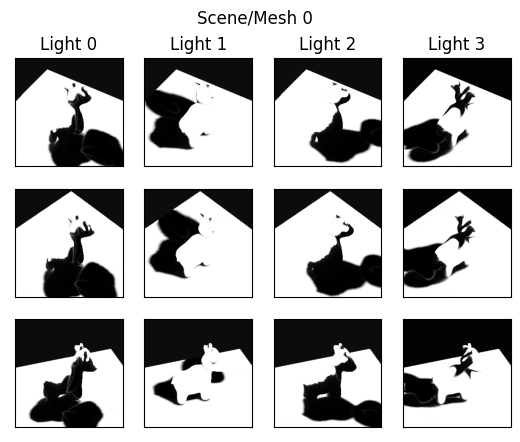

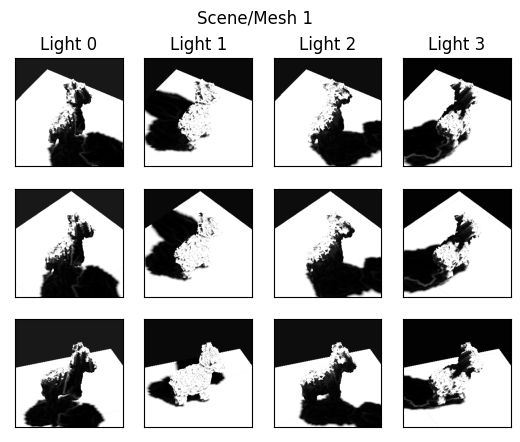

In [12]:
L         = 4
phi       = 2*math.pi*torch.rand(L)
radius    = 2
light_pos = torch.stack([radius*torch.sin(phi), 2*torch.ones_like(phi), radius*torch.cos(phi)], dim=-1)
light      = PointLights.create(light_pos, near=0.01, far=10, resolution=(256, 256), device=device)
shadow_map = render_shadow_map(render_context, v, f, None, light, method=ShadowMethod.VarianceShadowMaps)
shadow_map = filter_shadow_map(shadow_map, antialias=True, kernel=get_box_filter_2d(3, device=device))

position_world, _ = dr.interpolate(hnormalized(pre_rast.vertices), rast_out, pre_rast.faces)
position_world    = position_world.view(pre_rast.num_meshes, pre_rast.num_cameras, resolution[0], resolution[1], -1)

print(f"The 'position_world' tensor holds the world positions for {v.shape[0]} scenes/meshes and {view_matrices.shape[0]} cameras (first two dimensions): {position_world.shape=}")

visibility = compute_visibility(shadow_map=shadow_map, positions=position_world, bias=0.1)

print(f"The 'visibility' tensor holds the visibility for {v.shape[0]} scenes/meshes, {view_matrices.shape[0]} cameras, and {light.position.shape[0]} light sources (first three dimensions): {visibility.shape=}")

for i in range(visibility.shape[0]):
    fig, axs = plt.subplots(visibility.shape[1], visibility.shape[2])
    fig.suptitle(f"Scene/Mesh {i}")
    for j in range(visibility.shape[1]):
        for k in range(visibility.shape[2]):
            axs[j][k].imshow(to_display_image(visibility[i, j, k]), cmap='gray')
            axs[j][k].set_xticks([])
            axs[j][k].set_yticks([])

            if j == 0:
                axs[j][k].set_title(f"Light {k}")

normal.shape=torch.Size([2, 3, 4, 256, 256, 3])
direction.shape=torch.Size([2, 3, 4, 256, 256, 3])


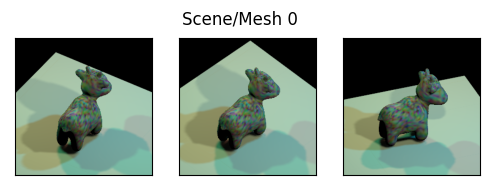

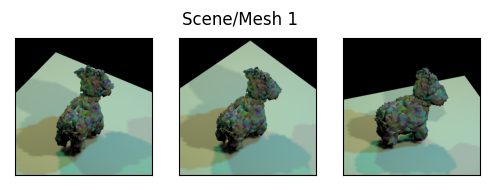

In [13]:
# Stack the normals of both scene meshes and then expand them to the number of cameras
# TODO: Complete Documentation
n = torch.stack([scene_mesh_1.normals, scene_mesh_2.normals], dim=0)
n = expand_per_mesh_tensor(pre_rast, n)
normal, _ = dr.interpolate(n, rast_out, tri=pre_rast.faces)
normal    = torch.repeat_interleave(normal, L, 0)
normal    = normal.reshape(2, C, L, resolution[1], resolution[0], 3)

d = torch.stack([scene_mesh_1.diffuse_albedo, scene_mesh_2.diffuse_albedo], dim=0)
d = expand_per_mesh_tensor(pre_rast, d)
diffuse_albedo, _ = dr.interpolate(d, rast_out, tri=pre_rast.faces)
diffuse_albedo    = torch.repeat_interleave(diffuse_albedo, L, 0)
diffuse_albedo    = diffuse_albedo.reshape(2, C, L, resolution[1], resolution[0], 3)

position        = position_world.reshape(-1, resolution[0], resolution[1], 3)
_, direction, _ = map_points_to_light_space(light, position)
direction       = direction.reshape(2, C, L, resolution[1], resolution[0], 3)

print(f"{normal.shape=}")
print(f"{direction.shape=}")

LdotN = dot(direction, normal, keepdim=True).clamp(0, 1)

light_colors = torch.rand_like(light.position)[None, None, :, None, None]

#
color = (diffuse_albedo/math.pi * light_colors * LdotN * 1/direction.norm(dim=-1, keepdim=True)**2 * visibility).sum(2)
color = dr.antialias(color.reshape(-1, resolution[1], resolution[0], 3), rast_out, pre_rast.v_clipspace, pre_rast.faces).reshape(2, C, resolution[1], resolution[0], 3)

for i in range(color.shape[0]):
    fig, axs = plt.subplots(1, color.shape[1], figsize=(6, 2))
    fig.suptitle(f"Scene/Mesh {i}")
    for j in range(visibility.shape[1]):
        axs[j].imshow(to_display_image(color[i, j]))
        axs[j].set_xticks([])
        axs[j].set_yticks([])